# Phase1_Project

> #### Objective : To provide to Microsoft Studio information on the kinds of movies that are doing well at the box office

In [10]:
# Importing relevant libraries

import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
conn = sqlite3.connect('im.db')

In [11]:
# initial look at the different tables
# converting all the tables into a df using the dataframe constructor 

movie_basics = pd.DataFrame(pd.read_sql('SELECT * FROM movie_basics',conn))
movie_basics.head()


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [12]:
movie_ratings = pd.DataFrame(pd.read_sql('SELECT * FROM movie_ratings',conn))
movie_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [13]:
movie_akas = pd.DataFrame(pd.read_sql('SELECT * FROM movie_akas',conn))
movie_akas.head()

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0


In [5]:
# Getting an idea of the size of the tables

print('Shape of movie_basics table :',movie_basics.shape)
print('Shape of movie_ratings table :',movie_ratings.shape)
print('Shape of movie_akas table : ',movie_akas.shape)


Shape of movie_basics table : (146144, 6)
Shape of movie_ratings table : (73856, 3)
Shape of movie_akas table :  (331703, 8)


> **From the shapes of the tables, we can see that there is a** ***disparity in the amount of data between the tables.***
**Let's start by analyzing the movie_basics table**

In [14]:
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


>We can see that **original_title, runtime_minutes and genres have missing values.**
 Getting an idea of the amount of missing data:

In [15]:
print('Number of rows missing in the original_title column :',len(movie_basics[movie_basics['original_title'].isna()]))
print('Number of rows missing in the runtime_miutes column :',len(movie_basics[movie_basics['runtime_minutes'].isna()]))
print('Number of rows missing in the genres column :',len(movie_basics[movie_basics['genres'].isna()]))


Number of rows missing in the original_title column : 21
Number of rows missing in the runtime_miutes column : 31739
Number of rows missing in the genres column : 5408


> Since the missing data in the **'original_title' is < 1%**, we can delete those rows without suffering any consequences


In [16]:
# using .dropna to remove rows with NaN values in the 'original_title' columns

movie_basics.dropna(subset=['original_title'], inplace = True)

In [17]:
# check to the see the if the numbers have changed

movie_basics.info()

# can see the number of rows have reduced from 146144 to 146123

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146123 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146123 non-null  object 
 1   primary_title    146123 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146123 non-null  int64  
 4   runtime_minutes  114401 non-null  float64
 5   genres           140734 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 7.8+ MB


> Since we will not be examining the runtime_minutes for our analysis, we can remove the column from the dataset.

In [18]:
movie_basics.drop('runtime_minutes', axis=1, inplace = True)
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146123 entries, 0 to 146143
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   movie_id        146123 non-null  object
 1   primary_title   146123 non-null  object
 2   original_title  146123 non-null  object
 3   start_year      146123 non-null  int64 
 4   genres          140734 non-null  object
dtypes: int64(1), object(4)
memory usage: 6.7+ MB


> Examining the 'genres' column:

In [22]:
movie_basics['genres'].isna().value_counts()

False    140734
True       5389
Name: genres, dtype: int64

> We can see that the genres column has 5389 missing values. Let's look at the values in the genres column

In [23]:
movie_basics['genres'].value_counts()

Documentary                    32185
Drama                          21486
Comedy                          9177
Horror                          4372
Comedy,Drama                    3519
                               ...  
Drama,Music,News                   1
Fantasy,History,Musical            1
Family,Horror                      1
Animation,Sci-Fi,Sport             1
Animation,Biography,Fantasy        1
Name: genres, Length: 1085, dtype: int64

> We can see that the values are varied(1085). Also, some movies are classified under 2-3 genres making it difficult for us to predict what the missing genres might be. 

> Since the amount of missing data for the genres is also quite large i.e 5389 rows, filling in missing values with guesswork can skew the analysis in any number of ways. So the best way would be to just classify the data as 'missing'

In [24]:
# filling the missing data with 'missing'
movie_basics['genres'].fillna('missing',inplace = True)

In [25]:
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146123 entries, 0 to 146143
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   movie_id        146123 non-null  object
 1   primary_title   146123 non-null  object
 2   original_title  146123 non-null  object
 3   start_year      146123 non-null  int64 
 4   genres          146123 non-null  object
dtypes: int64(1), object(4)
memory usage: 6.7+ MB


> The **movie_basics** table has now **no missing values**

> Next, since the ultimate goal is to be profitable, the info from the **movie_gross** is table is paramount for the analysis

In [26]:
# converting the movie_gross table into a dataframe
movie_gross = pd.DataFrame(pd.read_csv('bom.movie_gross.csv'))
movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


> Let's **combine movie_basics and the movie_gross tables** to get information on how much money each movie has made:

In [27]:
# using the merge method to combine the movie_basics and the movie_gross df's
# using the inner merge will give us only movie_titles that have gross amounts listed.
# any other merge method will result in a lot of redundant data

movie_gross_df = movie_basics.merge(movie_gross, how = 'inner', left_on = 'primary_title', right_on = 'title')
movie_gross_df.head()

,movie_id,primary_title,original_title,start_year,genres,title,studio,domestic_gross,foreign_gross,year
0,tt0315642,Wazir,Wazir,2016,"Action,Crime,Drama",Wazir,Relbig.,1100000.0,NaN,2016
1,tt0337692,On the Road,On the Road,2012,"Adventure,Drama,Romance",On the Road,IFC,744000.0,8000000,2012
2,tt2404548,On the Road,On the Road,2011,Drama,On the Road,IFC,744000.0,8000000,2012
3,tt3872966,On the Road,On the Road,2013,Documentary,On the Road,IFC,744000.0,8000000,2012
4,tt4339118,On the Road,On the Road,2014,Drama,On the Road,IFC,744000.0,8000000,2012


In [28]:
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 0 to 3365
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movie_id        3366 non-null   object 
 1   primary_title   3366 non-null   object 
 2   original_title  3366 non-null   object 
 3   start_year      3366 non-null   int64  
 4   genres          3366 non-null   object 
 5   title           3366 non-null   object 
 6   studio          3363 non-null   object 
 7   domestic_gross  3342 non-null   float64
 8   foreign_gross   2043 non-null   object 
 9   year            3366 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 289.3+ KB


> To look at total_gross, need to sum domestic_gross and foreign_gross. From the above we can see that foreign_gross is listed as an object data type. Need to convert this to float64 to be able to compute the sum

In [29]:
# removing the ',' from the string
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].str.replace(',','') 

# converting 'foreign_gross' to float datatype
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].astype('float64')


In [30]:
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 0 to 3365
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movie_id        3366 non-null   object 
 1   primary_title   3366 non-null   object 
 2   original_title  3366 non-null   object 
 3   start_year      3366 non-null   int64  
 4   genres          3366 non-null   object 
 5   title           3366 non-null   object 
 6   studio          3363 non-null   object 
 7   domestic_gross  3342 non-null   float64
 8   foreign_gross   2043 non-null   float64
 9   year            3366 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 289.3+ KB


> We can also see that there are some missing values in the domestic and foreign gross columns. Let's examine them:

In [39]:
print(movie_gross_df['domestic_gross'].isna().value_counts())
print(movie_gross_df['foreign_gross'].isna().value_counts())

False    3366
Name: domestic_gross, dtype: int64
False    2043
True     1323
Name: foreign_gross, dtype: int64


> Getting some stats of the domestic_gross column to see if we can impute values:

In [40]:
# we can create a function to compute the stats
# we can just the pass the series name as an argument into the function

def stats(column):
    
    mean_value = round(column.mean())
    median_value = round(column.median())
    std_dev = round(column.std())
    
    return mean_value, median_value,std_dev       

In [41]:
stat_values = stats(movie_gross_df['domestic_gross'])
stat_values

(29666555.0, 1950000.0, 65132297.0)

> Let's impute the median value for the missing data in the domestic_gross column and re-compute the stats to see if there is any discernible change

In [42]:
# Imputing the median value
movie_gross_df['domestic_gross'] = movie_gross_df['domestic_gross'].fillna(stat_values[1])

In [43]:
# checking to see if any missing data 
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 0 to 3365
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movie_id        3366 non-null   object 
 1   primary_title   3366 non-null   object 
 2   original_title  3366 non-null   object 
 3   start_year      3366 non-null   int64  
 4   genres          3366 non-null   object 
 5   title           3366 non-null   object 
 6   studio          3363 non-null   object 
 7   domestic_gross  3366 non-null   float64
 8   foreign_gross   2043 non-null   float64
 9   year            3366 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 289.3+ KB


> We can see that the domestic_gross has no more null values

In [37]:
# re-computing the stats
new_stat_values = stats(movie_gross_df['domestic_gross'])
new_stat_values

(29666555.0, 1950000.0, 65132297.0)

In [38]:
# Calculating percentage change:

mean_change = ((new_stat_values[0]-stat_values[0])/stat_values[0]) * 100
median_change = ((new_stat_values[1]-stat_values[1])/stat_values[1]) * 100
std_dev_change = ((new_stat_values[2]-stat_values[2])/stat_values[2]) * 100

print(mean_change, "", median_change, "", std_dev_change)

-0.6664591369126155  0.0  -0.2923781178926572


> We can see that there is less than 1% change if we impute the median value. So let's keep this.
  Next,let's examine the foreign gross column

In [44]:
movie_gross_df['foreign_gross'].isna().value_counts()

False    2043
True     1323
Name: foreign_gross, dtype: int64

> We can that there are 1323 empty values. Let's compute the stats again to get an idea of what we can impute.
First, we need to convert it to the float data type

In [45]:
# converting 'foreign_gross' to float datatype
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].astype('float64')


In [46]:
# compute the stats using the stats function defined earlier
fd_stats = stats(movie_gross_df['foreign_gross'])
fd_stats

(74551466.0, 19600000.0, 134783459.0)

> **Note about the data : the stats for the foreign gross cannot be considered to be wholly accurate due to large volume of missing data ( ~ 40%). But, this is what we have to work with. We can exclude the foreign_gross data if we choose to do so later**

In [47]:
#imputing the median value
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].fillna(fd_stats[1])

In [48]:
# check the table
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 0 to 3365
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movie_id        3366 non-null   object 
 1   primary_title   3366 non-null   object 
 2   original_title  3366 non-null   object 
 3   start_year      3366 non-null   int64  
 4   genres          3366 non-null   object 
 5   title           3366 non-null   object 
 6   studio          3363 non-null   object 
 7   domestic_gross  3366 non-null   float64
 8   foreign_gross   3366 non-null   float64
 9   year            3366 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 289.3+ KB


In [49]:
#re-compute stats
fd_new_stats = stats(movie_gross_df['foreign_gross'])
fd_new_stats

(52952895.0, 19600000.0, 108373000.0)

> Let's add a new column to see how much each movie grossed totally: domestic + overseas

In [50]:
movie_gross_df['total_gross'] = movie_gross_df['domestic_gross'] + movie_gross_df['foreign_gross']

In [201]:
# check to see if the total_gross column is created
movie_gross_df.head()

,movie_id,primary_title,original_title,start_year,genres,title,studio,domestic_gross,foreign_gross,year,total_gross
0,tt0315642,Wazir,Wazir,2016,"Action,Crime,Drama",Wazir,Relbig.,1100000.0,19600000.0,2016,20700000.0
1,tt0337692,On the Road,On the Road,2012,"Adventure,Drama,Romance",On the Road,IFC,744000.0,8000000.0,2012,8744000.0
2,tt2404548,On the Road,On the Road,2011,Drama,On the Road,IFC,744000.0,8000000.0,2012,8744000.0
3,tt3872966,On the Road,On the Road,2013,Documentary,On the Road,IFC,744000.0,8000000.0,2012,8744000.0
4,tt4339118,On the Road,On the Road,2014,Drama,On the Road,IFC,744000.0,8000000.0,2012,8744000.0


In [141]:
# function to find duplicated of columns
def find_duplicates(df, column_name):
    return df[column_name].duplicated().value_counts()

> Let's plot to see how much genres grossed

In [53]:
# creating a new df and using groupby to get total_gross by genres type
df_genres = movie_gross_df.groupby(['genres']).sum()
df_genres.reset_index(inplace = True)
df_genres.head()

,genres,start_year,domestic_gross,foreign_gross,year,total_gross
0,Action,44303,3.477635e+08,9.252000e+08,44318,1.272963e+09
1,"Action,Adventure",12076,3.245000e+05,8.244700e+07,12080,8.277150e+07
2,"Action,Adventure,Animation",44311,2.184660e+09,4.367500e+09,44318,6.552160e+09
3,"Action,Adventure,Biography",8062,2.402290e+08,5.881000e+08,8063,8.283290e+08
4,"Action,Adventure,Comedy",64493,3.172472e+09,6.631400e+09,64499,9.803872e+09


In [54]:
# sorting the total_gross column in descending order to get the highest grossing genres
df_genres.sort_values(by=['total_gross'], ascending = False, inplace = True, ignore_index=True)
df_genres.head()

,genres,start_year,domestic_gross,foreign_gross,year,total_gross
0,"Adventure,Animation,Comedy",151065,9.645133e+09,1.802100e+10,151076,2.766613e+10
1,"Action,Adventure,Sci-Fi",94658,1.102470e+10,1.663100e+10,94662,2.765570e+10
2,Drama,789516,4.611663e+09,9.435122e+09,789549,1.404679e+10
3,"Action,Adventure,Fantasy",62467,4.378787e+09,8.936100e+09,62470,1.331489e+10
4,"Action,Adventure,Comedy",64493,3.172472e+09,6.631400e+09,64499,9.803872e+09


In [55]:
# creating a new column of the total_gross re-formatted
df_genres["total_gross_$"] = df_genres["total_gross"].map('${:,.0f}'.format)
df_genres.head()

,genres,start_year,domestic_gross,foreign_gross,year,total_gross,total_gross_$
0,"Adventure,Animation,Comedy",151065,9.645133e+09,1.802100e+10,151076,2.766613e+10,"$27,666,132,597"
1,"Action,Adventure,Sci-Fi",94658,1.102470e+10,1.663100e+10,94662,2.765570e+10,"$27,655,702,388"
2,Drama,789516,4.611663e+09,9.435122e+09,789549,1.404679e+10,"$14,046,785,196"
3,"Action,Adventure,Fantasy",62467,4.378787e+09,8.936100e+09,62470,1.331489e+10,"$13,314,887,000"
4,"Action,Adventure,Comedy",64493,3.172472e+09,6.631400e+09,64499,9.803872e+09,"$9,803,872,299"


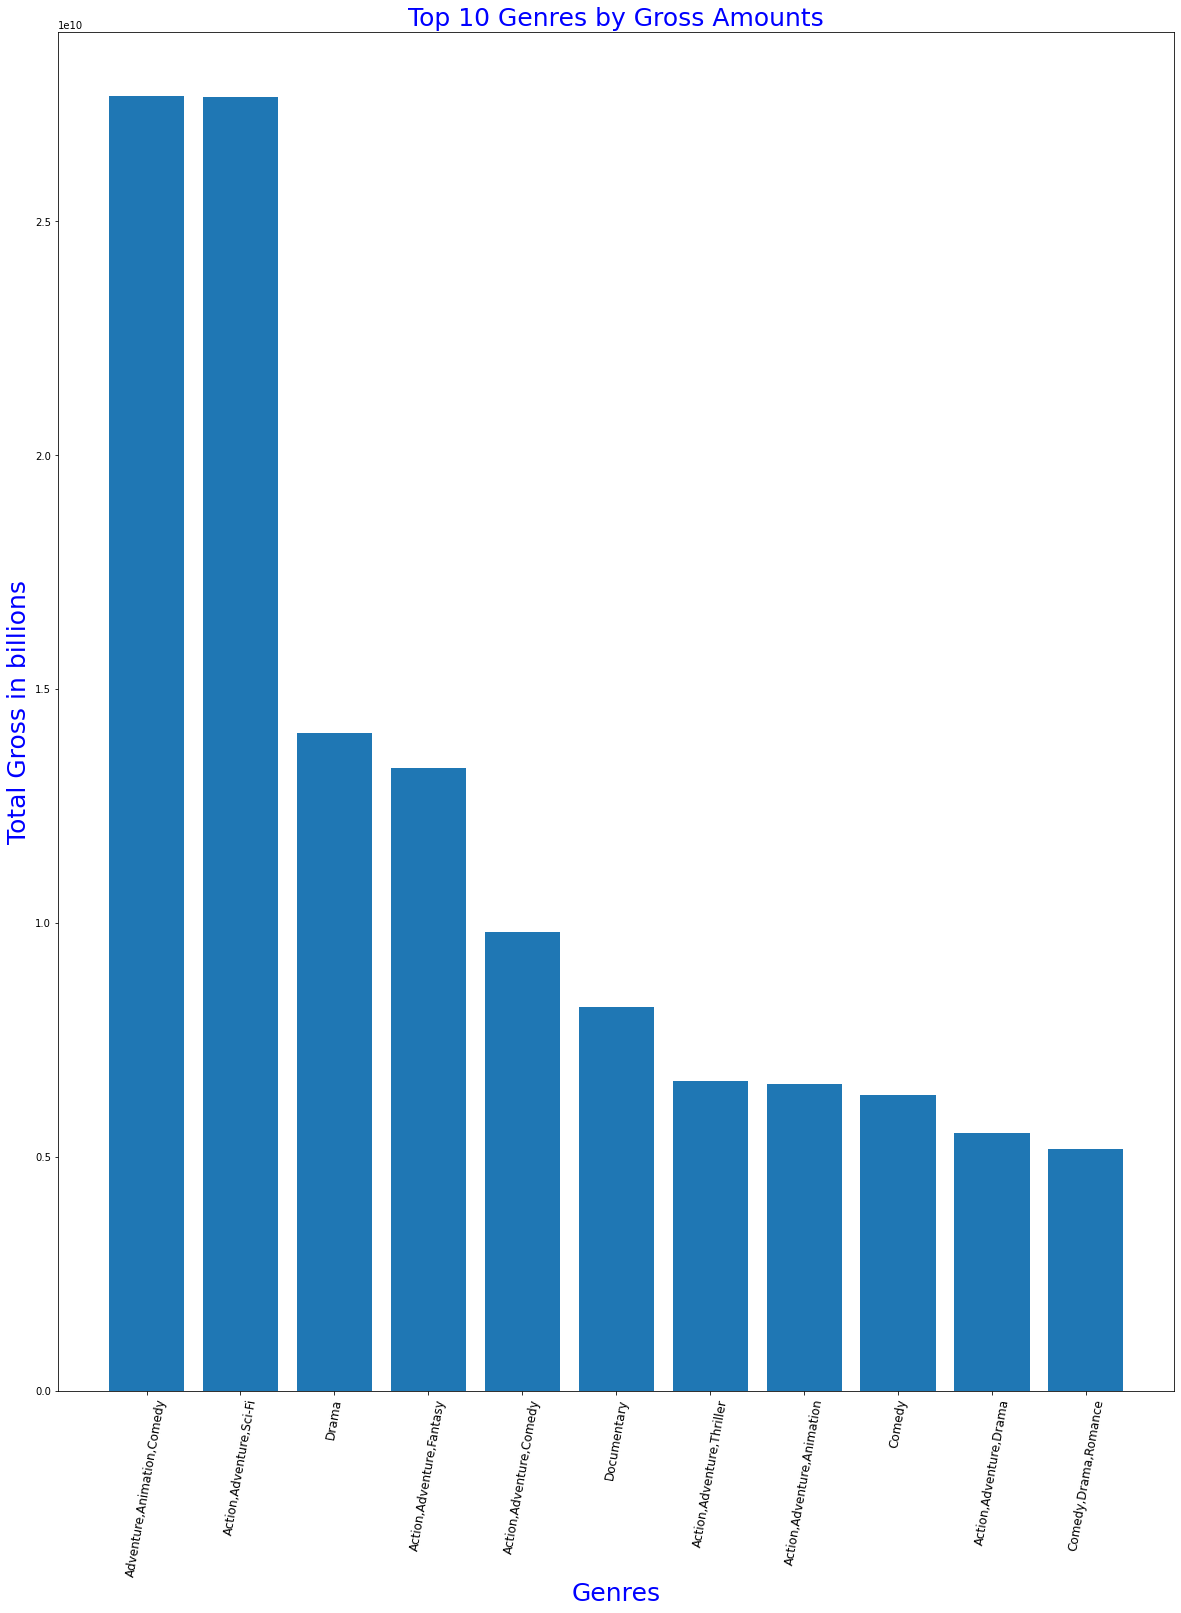

In [116]:
fig,ax = plt.subplots(figsize = (20,25))

ax.bar(x=df_genres.loc[0:10, 'genres'], height=df_genres.loc[0:10, 'total_gross'], width=0.8)
ax.tick_params(axis = 'x', labelsize = 12, labelrotation = 80)
ax.set_title('Top 10 Genres by Gross Amounts', fontdict = {'fontsize' : 25, 'color' :'blue'})
ax.set_xlabel('Genres', fontdict = {'fontsize' : 25, 'color' :'blue'})
ax.set_ylabel('Total Gross in billions', fontdict = {'fontsize' : 25, 'color' :'blue'})

plt.show()

> Let's look at which markets have grossed the highest amounts

In [127]:
movie_akas2 = movie_akas.drop_duplicates(subset = ['movie_id'], keep = 'first', ignore_index = True)
movie_akas2.head()

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0381957,1,Cloud Cuckoo Land,GB,None,None,None,0.0
2,tt0401729,10,Джон Картер: Мiж двох свiтiв,UA,None,None,None,0.0
3,tt10010134,1,Versailles Rediscovered - The Sun King's Vanis...,None,None,original,None,1.0
4,tt10027708,1,Miguelito - Canto a Borinquen,None,None,original,None,1.0


In [204]:
# Let's join the movie_basics and movie_akas table 
movie_markets = movie_basics.merge(movie_akas2, how = 'inner', on = 'movie_id')
movie_markets.head()

,movie_id,primary_title,original_title,start_year,genres,ordering,title,region,language,types,attributes,is_original_title
0,tt0063540,Sunghursh,Sunghursh,2013,"Action,Crime,Drama",1,Sangharsh,IN,hi,None,alternative transliteration,0.0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,"Biography,Drama",1,One Day Before the Rainy Season,XWW,en,None,None,0.0
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,Drama,10,La otra cara del viento,VE,None,None,None,0.0
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,"Comedy,Drama",1,Subse Bada Sukh,IN,bn,None,None,0.0
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,"Comedy,Drama,Fantasy",1,La Telenovela Errante,None,None,original,None,1.0


In [140]:
# checking to see if there are any duplicate values in movie_id's
movie_markets['movie_id'].duplicated().value_counts()

False    122300
Name: movie_id, dtype: int64

In [205]:
movie_markets_gross2 = movie_gross_df.merge(movie_markets, how = 'inner', on ='movie_id')
movie_markets_gross2.head()

,movie_id,primary_title_x,original_title_x,start_year_x,genres_x,title_x,studio,domestic_gross,foreign_gross,year,...,original_title_y,start_year_y,genres_y,ordering,title_y,region,language,types,attributes,is_original_title
0,tt0315642,Wazir,Wazir,2016,"Action,Crime,Drama",Wazir,Relbig.,1100000.0,19600000.0,2016,...,Wazir,2016,"Action,Crime,Drama",1,Wazir,None,None,original,None,1.0
1,tt0337692,On the Road,On the Road,2012,"Adventure,Drama,Romance",On the Road,IFC,744000.0,8000000.0,2012,...,On the Road,2012,"Adventure,Drama,Romance",10,En el camino,AR,None,imdbDisplay,None,0.0
2,tt2404548,On the Road,On the Road,2011,Drama,On the Road,IFC,744000.0,8000000.0,2012,...,On the Road,2011,Drama,1,On the Road,AM,None,None,None,0.0
3,tt3872966,On the Road,On the Road,2013,Documentary,On the Road,IFC,744000.0,8000000.0,2012,...,On the Road,2013,Documentary,1,On the Road,DE,None,None,None,0.0
4,tt4339118,On the Road,On the Road,2014,Drama,On the Road,IFC,744000.0,8000000.0,2012,...,On the Road,2014,Drama,1,Wo zai lu shang zui ai ni,CN,cmn,imdbDisplay,None,0.0


In [206]:
df_markets = movie_markets_gross2.groupby(['region']).sum()
df_markets.reset_index(inplace = True)
df_markets.head()

,region,start_year_x,domestic_gross,foreign_gross,year,total_gross,start_year_y,ordering,is_original_title
0,AL,2010,2.590000e+07,6.700000e+06,2010,3.260000e+07,2010,10,0.0
1,AM,2011,7.440000e+05,8.000000e+06,2012,8.744000e+06,2011,1,0.0
2,AR,114754,2.436009e+09,3.049356e+09,114769,5.485365e+09,114754,516,0.0
3,AT,16115,7.253020e+07,4.051000e+08,16113,4.776302e+08,16115,53,0.0
4,AU,40278,4.080374e+08,8.655000e+08,40269,1.273537e+09,40278,74,0.0


In [207]:
df_markets.sort_values(by = ['total_gross'], ascending = False, inplace = True, ignore_index = True)

In [208]:
df_markets.head()

,region,start_year_x,domestic_gross,foreign_gross,year,total_gross,start_year_y,ordering,is_original_title
0,US,690752,1.035034e+10,1.661247e+10,690813,2.696282e+10,690752,1090,0.0
1,RS,132910,3.764871e+09,7.003512e+09,132932,1.076838e+10,132910,624,0.0
2,UA,104719,3.830018e+09,5.819570e+09,104724,9.649588e+09,104719,484,0.0
3,BR,235642,3.614321e+09,5.709875e+09,235658,9.324196e+09,235642,927,0.0
4,IT,149033,3.567004e+09,5.757067e+09,149044,9.324071e+09,149033,677,0.0


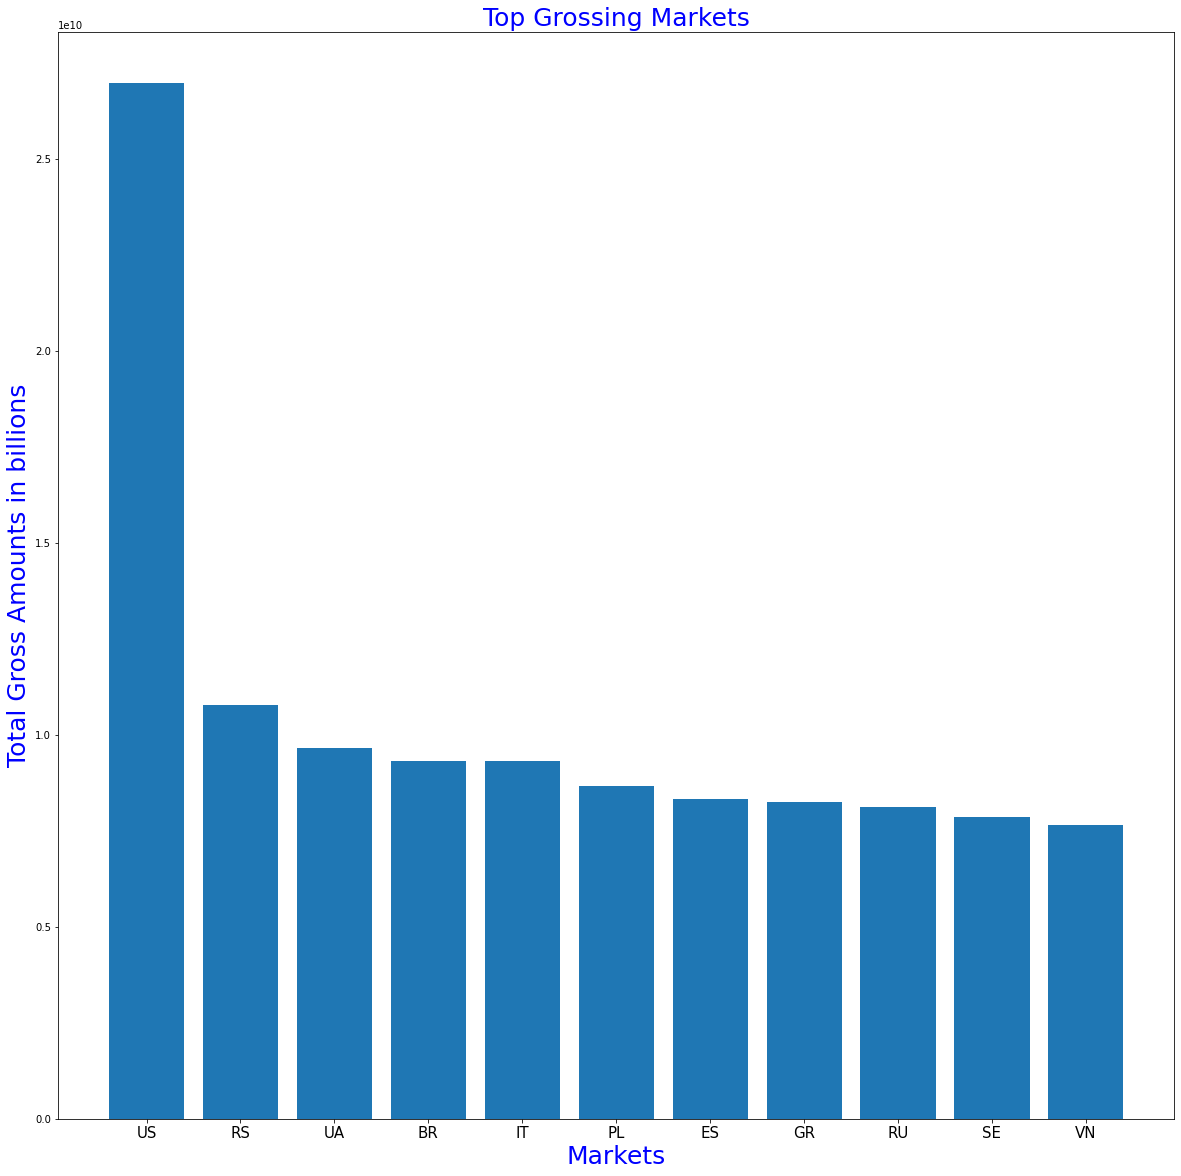

In [209]:
fig1, ax1 = plt.subplots(figsize = (20,20))

ax1.bar(x = df_markets.loc[:10, 'region'], height = df_markets.loc[:10, 'total_gross'])
ax1.tick_params(axis = 'x', labelsize = 15)
ax1.set_title('Top Grossing Markets', fontdict = {'fontsize' : 25, 'color' :'blue'})
ax1.set_xlabel('Markets', fontdict = {'fontsize' : 25, 'color' :'blue'} )
ax1.set_ylabel('Total Gross Amounts in billions', fontdict = {'fontsize' : 25, 'color' :'blue'})
plt.show()

> Next step would be to see which genres grossed the most amount in the US market i.e breakdown of the gross amounts of the top 10 genres in the US market.